# ML Reverse Lecture

In this lab we will look at some examples on how to use ML for classification tasks over a music dataset.

Specifically, we will use a Kaggle dataset with 218k songs [fetched from Spotify](https://github.com/tgel0/spotify-data). It has a schema that is almost identical to the one we used for lab 2, but with two additional columns: `genre`, and `popularity`. Schema columns are described in the [Spotify API docs](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

First, we will do some data exploration over the top 1k most popular songs in the dataset. Our goal in this phase is to understand some of the characteristics that these most popular songs have in common. We'll use visualization techniques and unsupervised ML (k-means clustering, PCA) to better understand the relationship between some of the features.

Next, we'll try out a genre prediction task on the entire 218k songs dataset. We'll use supervised ML (classification) for this, and give you a chance to try out the same problem using regression.

Finally, we'll see if we can use what we learned during the genre prediction task to try and predict song popularity.


## Running this notebook

To execute code from a cell, you can either click `Run` at the top, or type `shift+Enter` after clicking a cell.  You can either run the entire notebook (`Restart & Run All` from the `Kernel` drop-down), or run each cell individually.  If you choose the latter, note that it is important that you run cells in order, as later cells depend on earlier ones. And to be able to `Run All` successfully, you'll have to write code for answering some of the questions in the notebook.

Once you open your notebook on the browser, and check that the cells are rendering correctly (e.g., try running the "Python packages" cell below), we're good to go from there.

## Python packages we'll need

First, import the python packages we'll be using for the lab:

In [1]:
# Dataframes.
import pandas as pd
import numpy as np

# Plotting.
import matplotlib.pyplot as plt
#%matplotlib notebook  # for interactive plots
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# ML.
from sklearn import tree
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Ignore warnings.
import warnings
warnings.simplefilter("ignore")

## Part 1: data exploration

First, we load our dataset into a pandas dataframe. Next, we store the top 1k most popular songs in a separate `top1k` dataframe.

**Q1: Filter `df` for the top 1000 songs with largest `popularity` values, and store it on a `top1k` dataframe below.**

In [2]:
df = pd.read_csv('data/spotify_songs.csv')

# Q1: YOUR CODE GOES HERE.
# top1k = (...)

# Q1: Sample answer.
top1k = df.sort_values('popularity', ascending=False).head(1000)

Let's make sure that loading our data worked as we expect. A natural way to do that is to inspect the first few entries with [`head()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html):

In [3]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,21,0.986,0.313,490867,0.23100,0.000431,C#,0.0964,-14.287,Major,0.0547,86.001,4/4,0.0886
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,18,0.972,0.360,176797,0.20100,0.028000,D#,0.1330,-19.794,Major,0.0581,131.798,4/4,0.3690
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,10,0.935,0.168,266184,0.47000,0.020400,C,0.3630,-8.415,Major,0.0383,75.126,3/4,0.0696
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,17,0.961,0.250,288573,0.00605,0.000000,D,0.1200,-33.440,Major,0.0480,76.493,4/4,0.0380
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,19,0.985,0.142,629760,0.05800,0.146000,D,0.0969,-23.625,Major,0.0493,172.935,4/4,0.0382


We can see that most of these columns are familiar to us, as they were present in our `top2018.csv` dataset from lab 2. The additional columns here are only `genre` and `popularity`.

Let's examine the data types for each of the columns using [`info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html):

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228159 entries, 0 to 228158
Data columns (total 18 columns):
genre               228159 non-null object
artist_name         228159 non-null object
track_name          228159 non-null object
track_id            228159 non-null object
popularity          228159 non-null int64
acousticness        228159 non-null float64
danceability        228159 non-null float64
duration_ms         228159 non-null int64
energy              228159 non-null float64
instrumentalness    228159 non-null float64
key                 228159 non-null object
liveness            228159 non-null float64
loudness            228159 non-null float64
mode                228159 non-null object
speechiness         228159 non-null float64
tempo               228159 non-null float64
time_signature      228159 non-null object
valence             228159 non-null float64
dtypes: float64(9), int64(2), object(7)
memory usage: 31.3+ MB


The output of `df.info()` tells us that we have:
- 7 `object` columns: (`genre`, `artist_name`, `track_name`, `track_id`, `key`, and `time_signature`)
- 2 `int64` columns (`popularity` and `duration_ms`)
- 9 `float64` (remaining columns)

We can also take a look at aggregate stats for each of the numerical columns (both discrete `int64`, and continuous `float64`) the dataset has by running [`describe()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html):

In [5]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,228159.000000,228159.000000,228159.000000,2.281590e+05,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000,228159.000000
mean,44.209130,0.351200,0.554198,2.366092e+05,0.580967,0.137310,0.214638,-9.354658,0.122442,117.423062,0.444795
std,17.276599,0.351385,0.183949,1.166787e+05,0.260577,0.292447,0.196977,5.940994,0.186264,30.712458,0.255397
min,0.000000,0.000001,0.056900,1.550900e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,33.000000,0.030900,0.437000,1.862530e+05,0.405000,0.000000,0.097700,-11.287000,0.036800,92.734000,0.232000
50%,47.000000,0.205000,0.570000,2.211730e+05,0.618000,0.000037,0.128000,-7.515000,0.050600,115.347000,0.430000
75%,57.000000,0.689000,0.690000,2.648400e+05,0.793000,0.023400,0.263000,-5.415000,0.109000,138.887000,0.643000
max,100.000000,0.996000,0.987000,5.552917e+06,0.999000,0.999000,1.000000,1.585000,0.967000,239.848000,1.000000


Except for `popularity`, `duration_ms`, `loudness`, and `tempo`, most of the numerical features are already scaled between 0.0 and 1.0.

**Q2: Looking at the documentation for [describe()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html), what's a command to describe categorical features? Why is the output different for categorical vs numerical features?**

In [6]:
# Q2: YOUR CODE GOES HERE
# df.describe(...)

# Q2: Sample answer.
df.describe(include=['O'])

,genre,artist_name,track_name,track_id,key,mode,time_signature
count,228159,228159,228159,228159,228159,228159,228159
unique,26,13318,130254,153685,12,2,5
top,Comedy,Giuseppe Verdi,Home,6sVQNUvcVFTXvlk3ec0ngd,C,Major,4/4
freq,9681,1394,111,10,26538,147123,198092


Next, let's check whether this dataset has missing data in the form of `null`s:

**Q3: How would you check whether your data set has null values in any of its columns? Did you find any?**

In [7]:
# Q3: YOUR CODE GOES HERE.
# df.(...)

# Q3: Sample answer.
df.isnull().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

Let's examine the dataset's [correlation matrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to see how column values co-occur with each other. This can help us spot features that may be predictive of other features in the dataset:

In [8]:
corr = df.corr()
corr.style.background_gradient().set_precision(2)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
popularity,1,-0.42,0.29,-0.041,0.28,-0.23,-0.2,0.41,-0.19,0.11,0.12
acousticness,-0.42,1,-0.38,0.035,-0.72,0.32,0.086,-0.7,0.17,-0.24,-0.34
danceability,0.29,-0.38,1,-0.12,0.34,-0.36,-0.034,0.45,0.14,0.019,0.54
duration_ms,-0.041,0.035,-0.12,1,-0.058,0.095,0.0068,-0.069,-0.018,-0.028,-0.14
energy,0.28,-0.72,0.34,-0.058,1,-0.39,0.18,0.82,0.14,0.23,0.45
instrumentalness,-0.23,0.32,-0.36,0.095,-0.39,1,-0.13,-0.52,-0.17,-0.11,-0.3
liveness,-0.2,0.086,-0.034,0.0068,0.18,-0.13,1,0.036,0.52,-0.056,0.018
loudness,0.41,-0.7,0.45,-0.069,0.82,-0.52,0.036,1,-0.0089,0.23,0.41
speechiness,-0.19,0.17,0.14,-0.018,0.14,-0.17,0.52,-0.0089,1,-0.086,0.035
tempo,0.11,-0.24,0.019,-0.028,0.23,-0.11,-0.056,0.23,-0.086,1,0.12


It seems that `energy` and `loudness` is the pair of features with the strongest positive correlation, followed by `valence` and `danceability`. We also see strong negative correlation between `acousticness` and a few other features. Finally, some of these have a medium to strong correlation with popularity.

**Q4: Why don't we see `genre`, `key`, and `time signature` on the correlation matrix? What could we do to address this?**

**A:** This is because they're categorical features, and the correlation matrix can only correlate values for numerical (discrete or continuous) features. One way to include the categorical features in a correlation matrix is to map each unique string to an integer value. This preprocessing step is also known as ["one-hot encoding"](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding). You can do this manually, as we do later in Part 3 of this notebook, or you can use `sklearn`'s [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#targetText=sklearn.preprocessing%20.OneHotEncoder).

If we look at the [documentation for these features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/), we see that `energy` is defined as a "perceptual measure of intensity and activity".  The example they give for this is death metal (high energy) vs a Bach prelude (low energy). Similarly, `valence` is a score between `0.0` and `1.0` indicating how positive the song is. So it makes sense that the `energy` would be correlated with `loudness`, and `valence` with `danceability`.

Now let's examine the distribution values for some of the features we mention above. In particular, let's look at the `top1k` subset, as we may have a better intuition for popular songs. For example, are the `top1k` songs more biased towards high `danceability`?

We can use [`seaborn's distplot()`](http://seaborn.pydata.org/generated/seaborn.distplot.html) to plot a histogram for the `danceability` column:

Text(0.5, 1.0, 'Danceability distribution for top 1k songs')

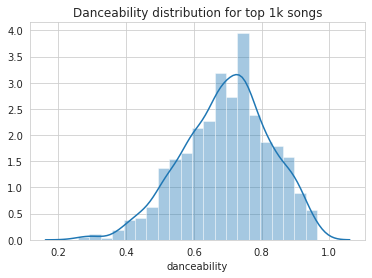

In [9]:
sns.distplot(top1k['danceability']).set_title('Danceability distribution for top 1k songs')

How about `energy` and `acousticness`? From the API docs: acousticness is a score between 0.0 and 1.0 that indicates Spotify's confidence that the song is "acoustic", e.g., live performances would have a score close to or equal to 1.0. 

**Q5: Plot the distribution for energy and acousticness below.  What is the mean for each?**

Mean energy:  0.6502619999999999
Mean acousticness:  0.197825639


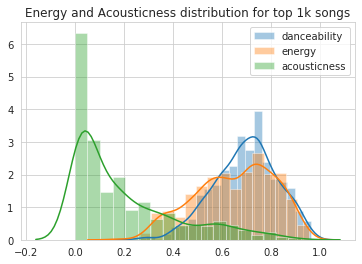

In [10]:
# Q5: YOUR CODE GOES HERE
# (...)

# Q5: Sample answer.
print('Mean energy: ', top1k['energy'].mean())
print('Mean acousticness: ', top1k['acousticness'].mean())

# All 3 series in one plot, for easier comparison.
p = sns.distplot(top1k['danceability'], label='danceability')
sns.distplot(top1k['energy'], label='energy')
sns.distplot(top1k['acousticness'], label='acousticness')
p.set_title('Energy and Acousticness distribution for top 1k songs')
p.set_xlabel('')  # remove x-axis label, o/w it uses the name from the last series that was added
p.legend()

**Q6: Discuss with the person next to you: what have we learned so far on the relationship between top1k songs and these 3 features above? How do you think this may affect our `popularity` prediction task?**

**In other words, what kind of song would you write if you were trying to make it to the top as a musician, just based on these 3 features alone?**

**A:** Low on acousticness, and high on both energy and danceability, i.e., make sure you write songs that are recorded in a studio, and that are both danceable and suitable for a gym workout ;)

## Part 2: unsupervised ML with k-means clustering

What if instead examining feature by feature we were to try and group songs by how similar they are in terms of these features?

If you think of each song as a vector in a multidimensional space, where each dimension is a feature in the dataset, we can use co-sine similarity as a "similarity" metric to group together (or "cluster") songs that are similar.  And using the same idea, we can also "profile" each group, or "cluster".

An unsupervised ML algorithm that can help us here is [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). `K` stands for the number of clusters (or groups) you want to have. The term `mean` refers to the method you use to assign each element in the dataset to a target cluster: by choosing the nearest mean (also known as the "centroid" element, representing the cluster) to that element.

Specifically, for our case, given a set of songs where each song is a `d-`dimensional real vector, `k-`means clustering aims to partition the set of songs into `k` clusters so as to minimize the within-cluster sum of squares (aka intra-cluster variance).

At this point we don't know yet how many clusters we'll need, but let's give it a try using some of the features we've seen so far, plus other characteristics such as `speechiness` (i.e., amount of vocals in the song), and `instrumentalness`.

In [11]:
# We exclude non-numerical features, and those that are too fine-grained, such as "key", or too coarse-grained,
# such as "mode".
df_numerical = top1k.select_dtypes(exclude=[np.object])
cluster_features = ['acousticness', 'danceability', 'energy', 'speechiness', 'instrumentalness']
df_clusters = df_numerical[cluster_features]

# numpy array with features
X = np.array(df_clusters)

# Q7: Do we need this scaling code?
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Hint: does this help you decide?
#top1k[cluster_features].describe()

How many clusters should we use? If we pick too few, we get too many songs that don't quite "fit in" with that cluster (i.e., intra-cluster variance, or error, is too large). If we pick too many, error is minimized, but our clusters are too small.

To figure out the "sweet spot", we can plot how the error decays as a function of the number of clusters we use.  This will give us a "elbow" shaped curve, and we can use the point at which the curve turns "smooth" as our number of clusters:

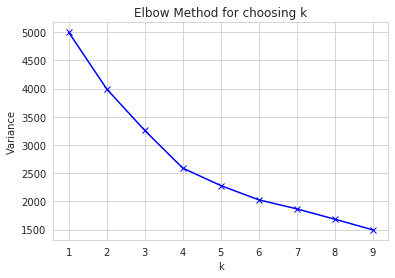

In [12]:
dist = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, init='k-means++', random_state=1337)
    km = km.fit(X)
    dist.append(km.inertia_)
    
plt.plot(range(1, 10), dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Variance')
plt.title('Elbow Method for choosing k')
plt.show()

**Q7: We used co-sine distance between songs (represented as n-dimensional vectors) to cluster them a 5-D space (n=5 features).  A [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) standardizes features by removing the mean and scaling to unit variance.  Do we need to use that scaler in our features (see code 2 cells above)? Plot the elbow method above both with and without scaler to see the difference.**

**A:** In general, it depends. When you have features with large values, and you don't want those to have larger weight on the distance calculation, then you want to scale. In our case, all 5 features have values ranging from 0.0 to 1.0. They're not scaled yet, however, as you can see from the output of `top1k[cluster_features].describe()`. You can also confirm that scaling is needed by looking at the elbow curve results: the breakpoint ends up being much earlier (at `k=2`) without scaling.

We can see from the "Elbow Method" curve above that at `k=4` our curve starts turning smooth. We can use either `k=4` or `k=5` as our number of clusters for k-means below. We'll go with `k=5`:

In [13]:
# k-means clustering
kmeans = KMeans(n_clusters=5, random_state=1337)
kmeans.fit(X)
y = kmeans.predict(X)

We can now try and visualize the clusters in a 2-D space:

Features:
 ['acousticness', 'danceability', 'energy', 'speechiness', 'instrumentalness']
Centroids:
 [[ 0.26738476  0.11318532 -0.18755981 -0.47252187  5.58850807]
 [-0.14284159  0.62984688  0.1625441  -0.31638741 -0.11293294]
 [-0.5010746  -0.79433895  0.56679914 -0.42829863 -0.13576529]
 [-0.40045451  0.66232282 -0.32472655  1.73669593 -0.15165669]
 [ 1.84854124 -0.64607645 -1.22526308 -0.19348971 -0.10663343]]


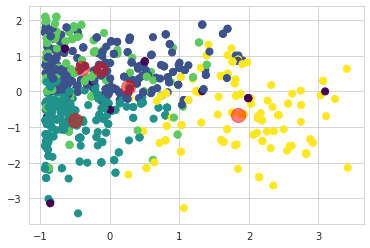

In [14]:
# visualize the clusters
centers = kmeans.cluster_centers_
print('Features:\n', cluster_features)
print('Centroids:\n', centers)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

The centroid values for each dimension tells us some information on what the cluster profiles are, e.g., the last cluster is high on acousticness and low on both danceability and energy, so it's likely capturing live performances.

But otherwise, as it turns out, directly visualizing the clusters in a 2-D space isn't so helpful for us at this point.

First, we're using a 5-D dimensional space for clustering, so without doing something smart about how we reduce the number of dimensions when polotting, we're losing a lot of information on the visualization above.  Second, most songs in this dataset are highly biased towards one end of each of some features (e.g., we have a lot more danceable songs than we have non-danceable ones), so we'll have a lot of clusters fairly close to each other.

We have a few options for dimensionality reduction that can help us here. The first one is Principal Component Analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)). Using PCA, we can tell what is the smallest set of features that contain the most information about our dataset:

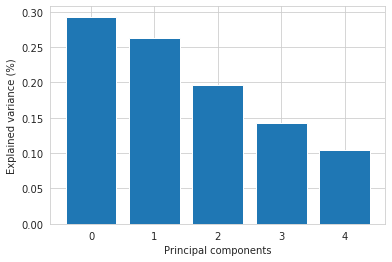

In [15]:
pca = PCA(n_components=len(cluster_features))
pca_components = pca.fit_transform(X)

# plot the PCA variances
pca_features = range(pca.n_components_)
plt.bar(pca_features, pca.explained_variance_ratio_)
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
plt.xticks(pca_features)

# save pca components in a df
pca_components = pd.DataFrame(pca_components, columns = ['PC0', 'PC1', 'PC2', 'PC3', 'PC4'])

We can see from the plot above that after the second PC, the gain in information is reduced. That is, the first component contributes almost 30% of the information, and the second one contributes over 25%. So if we use just the first 2 PCs, we already have close to 60% of the data being preserved. If we kept the first 3 PCs, we get closer to 80%.

Let's try and plot the k-means clusters using PCA instead, and see if that makes it easier to visualize the clusters:

Text(0, 0.5, 'Principal Component 2')

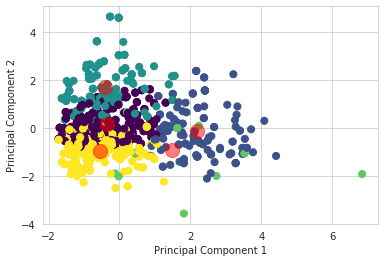

In [16]:
# k-means clustering on first 2 PCA components
X_pca = pca_components
kmeans_pca = KMeans(n_clusters=5, random_state=31337)
kmeans_pca.fit(X_pca)
y_pca = kmeans_pca.predict(X_pca)

# visualize the clusters
centers_pca = kmeans_pca.cluster_centers_
plt.scatter(X_pca['PC0'], X_pca['PC1'], c=y_pca, s=50, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.5);
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# if you're curious, inspect the min and max values for the PC dimensions
# X_pca[['PC0', 'PC1']].describe()

As we can see above, using k-means clustering after PCA, and plotting our clusters with the first 2 PCs as dimensions, helps a bit. Specifically, intra-cluster variance is smaller, and we can see that the centroids are not that far apart from each other (likely indicating that songs in the top1k are not that different from each other). But we can still improve this visualization.

A more powerful technique for dimensionality reduction is t-Distributed Stochastic Neighbor Embedding ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)). We'll leave for you to **try on your own** by following this [t-SNE vs PCA tutorial](https://www.datacamp.com/community/tutorials/introduction-t-sne), which has several example comparisons between the results you get with PCA vs t-SNE for visualization.

## Part 3: supervised ML for prediction tasks

For this last part, we'll focus on two prediction tasks.

In the first task, we'll try and predict genre for each song. We'll first try and see if we can do that on the `top1k` songs, and then with the entire dataset.

In the second task, we'll try to predict song popularity, but using a larger dataset with features similar to those of the dataset above.

### a) genre prediction

As mentioned above, the dataset we've been using so far has been augmented with genre information (stored in the `genre` column). We'll use values in that column as labels for training a supervised ML algorithm to predict song genre.

And unlike in k-means clustering, here we'll use all features as input. We start by scaling our dataset again, follow that by splitting into our data into training and test datasets:

In [17]:
# use our entire set of numerical features, instead of just the 5 we used for k-means clustering:
df_numerical = top1k.select_dtypes(exclude=[np.object])
X = np.array(df_numerical)

# scaling won't make a difference for classifiers, but we leave it here in case you want to try other models
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# the features and the label we'll use for training our supervised algo:
features = X
labels = top1k['genre']

# split our data into training and test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=31337)

We then train our [decision tree classifier](https://scikit-learn.org/stable/modules/tree.html):

In [18]:
# train a decision tree on it
genre_tree = DecisionTreeClassifier(random_state=31337)
genre_tree.fit(train_features, train_labels)

# predict labels on test data
pred_labels_tree = genre_tree.predict(test_features)

Let's see how well the tree did on our genre prediction task:

In [19]:
tree_results = classification_report(test_labels, pred_labels_tree)
print('Decision Tree Results:\n',  tree_results)

Decision Tree Results:
                   precision    recall  f1-score   support

     Alternative       0.00      0.00      0.00         3
           Anime       0.00      0.00      0.00         5
           Blues       0.00      0.00      0.00         8
Children’s Music       0.00      0.00      0.00         2
         Country       0.00      0.00      0.00         2
           Dance       0.05      0.09      0.07        33
      Electronic       0.00      0.00      0.00         0
            Folk       0.00      0.00      0.00         1
         Hip-Hop       0.04      0.06      0.05        31
           Indie       0.00      0.00      0.00         3
             Pop       0.17      0.15      0.16        89
             R&B       0.00      0.00      0.00         6
             Rap       0.00      0.00      0.00        44
       Reggaeton       0.33      0.15      0.21        13
            Rock       0.00      0.00      0.00        10

        accuracy                           0.0

That's pretty bad: our weighted average precision is as bad as random.  This is probably because this dataset doesn't have enough samples of each genre (there are only 1000 songs in total). As expected, we have a bias only towards genres in the top 1000.

**Q8: Did we pick the wrong model? Try a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) instead below, and see if we can get better results:**

**A:** We didn't pick the wrong model. As you can see below, the RFC results are a little better, but not by much.  Another problem here is that not only do we have a small dataset, but we also have a large number of genres relative to the size of the dataset. So it's a multiclass prediction task, with several classes, and too little samples per class.

In [20]:
# Q8: YOUR CODE GOES HERE.
# (...)

# Q8: Sample answer.
# train a random forest classifier
genre_forest = RandomForestClassifier(random_state=31337)
genre_forest.fit(train_features, train_labels)

# predict labels on test data
pred_labels_forest = genre_forest.predict(test_features)

forest_results = classification_report(test_labels, pred_labels_forest)
print('RFC Results:\n',  forest_results)

RFC Results:
                   precision    recall  f1-score   support

     Alternative       0.00      0.00      0.00         3
           Anime       0.00      0.00      0.00         5
           Blues       0.00      0.00      0.00         8
Children’s Music       0.00      0.00      0.00         2
         Country       0.00      0.00      0.00         2
           Dance       0.04      0.06      0.05        33
            Folk       0.00      0.00      0.00         1
         Hip-Hop       0.06      0.06      0.06        31
           Indie       0.00      0.00      0.00         3
           Movie       0.00      0.00      0.00         0
             Pop       0.24      0.25      0.24        89
             R&B       0.00      0.00      0.00         6
             Rap       0.10      0.07      0.08        44
       Reggaeton       0.33      0.15      0.21        13
            Rock       0.10      0.10      0.10        10

        accuracy                           0.13       25

Another problem here is that not only do we have a small dataset, but we also have a large number of genres relative to the size of the dataset.

Let's try and see if we can do better with more samples by using the larger dataset, and also reducing it down to prediction of only 3 mainstream genres:

**Q9: How many samples do we have per genre on the larger dataset (`df` pd dataframe)?** 

**A:** From the results below, we can see that aside from "A Capella" we have around 8k to under 10k samples per genre.

In [21]:
# Q9: YOUR CODE GOES HERE.
# df.(...)

# Q9: Sample answer.
df['genre'].value_counts().sort_index()

A Capella            119
Alternative         9353
Anime               9353
Blues               9353
Children’s Music    9353
Classical           9256
Comedy              9681
Country             8664
Dance               8701
Electronic          9377
Folk                9299
Hip-Hop             9295
Indie               9543
Jazz                9441
Movie               7806
Opera               8280
Pop                 9386
R&B                 8992
Rap                 9232
Reggae              8771
Reggaeton           8927
Rock                9272
Ska                 8874
Soul                9089
Soundtrack          9646
World               9096
Name: genre, dtype: int64

This may be enough, but as we can see the number of samples is not exactly balanced for each genre, so we may still get some bias.  Also, it's a fair amount of genres, so let's pick 3 common ones and see how we can do at that task. We'll go with "Hip-Hop", "Rock", and "Jazz", which should be different enough from each other:

In [22]:
hip_hop = df.loc[df['genre'] == 'Hip-Hop']
rock = df.loc[df['genre'] == 'Rock']
jazz = df.loc[df['genre'] == 'Jazz']

# make it equal number of songs for each
hip_hop = hip_hop.sample(n=len(rock), random_state=31337)
jazz = jazz.sample(n=len(rock), random_state=31337)
df = pd.concat([rock, hip_hop, jazz])

And train our forest on this larger dataset:

In [23]:
# select only numerical features
df_numerical = df.select_dtypes(exclude=[np.object])
X = np.array(df_numerical)

# scaling won't make a difference for classifiers, but we leave it here in case you want to try other models
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)

# features and label
features = X
labels = df['genre']

# split our data into training and test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=31337)

# train a RFC on it
genre_forest = RandomForestClassifier(random_state=31337)
genre_forest.fit(train_features, train_labels)

# predict labels on test data
pred_labels_forest = genre_forest.predict(test_features)

Let's see how we did this time around:

In [24]:
genre_forest_results = classification_report(test_labels, pred_labels_forest)
print('RFC Results:\n',  genre_forest_results)

RFC Results:
               precision    recall  f1-score   support

     Hip-Hop       0.86      0.89      0.88      2345
        Jazz       0.92      0.91      0.92      2264
        Rock       0.87      0.85      0.86      2345

    accuracy                           0.88      6954
   macro avg       0.88      0.88      0.88      6954
weighted avg       0.88      0.88      0.88      6954



This time around we did a lot better: 92% precision for Jazz, and an average precision of 88% for all 3 genres.

**Q10: To try on your own: train a [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with different values of `max_depth` and use `tree.plot()` to [`plot it`](https://scikit-learn.org/stable/modules/tree.html).**

**What are some pros/cons of using a decision tree vs a random forest classifier?**

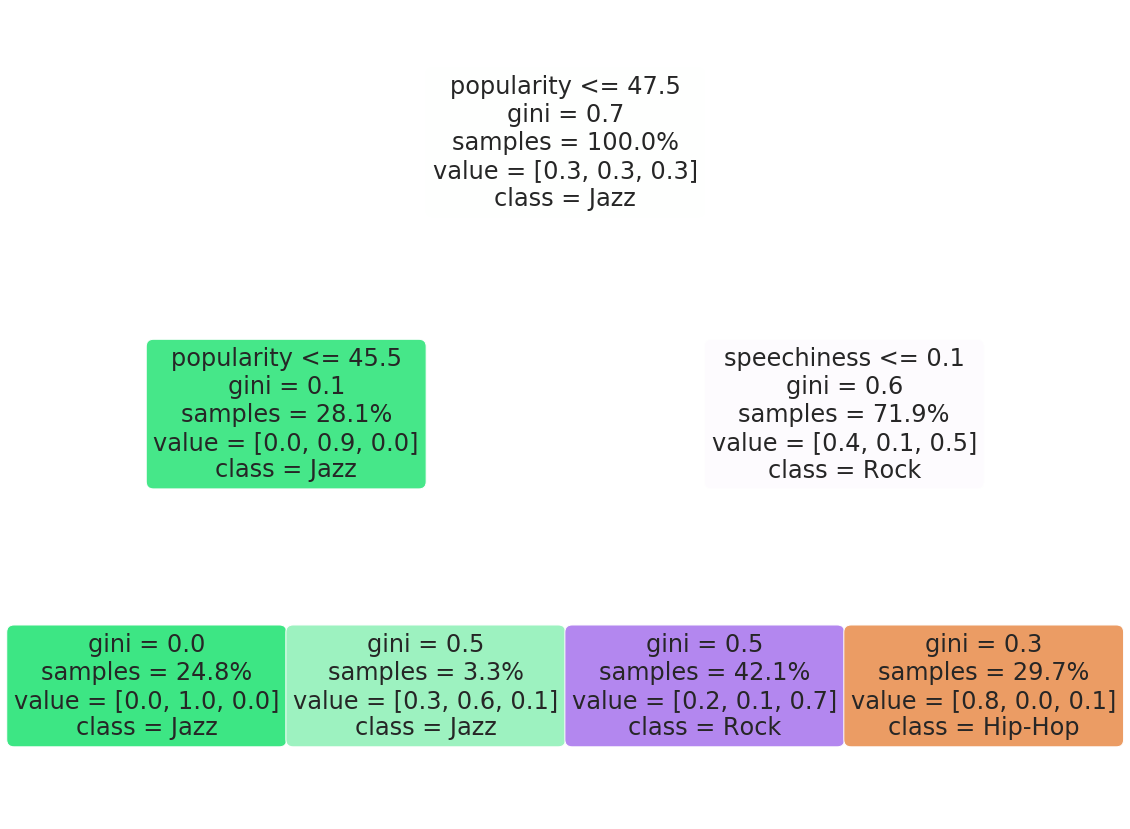

In [25]:
# Q10: YOUR CODE GOES HERE
# (...)


# Q10: Sample answer.

# train a decision tree on it with small depth, e.g., k=2
genre_tree = DecisionTreeClassifier(random_state=31337, max_depth=2)
genre_tree.fit(train_features, train_labels)

# predict labels on test data
pred_labels_tree = genre_tree.predict(test_features)

# plot tree using sklearn's plot_tree. you can also try using more
# advanced tree visualizations, e.g., https://explained.ai/decision-tree-viz/
feature_names = list(df_numerical.columns)
plt.figure(figsize=(20,15))
tree.plot_tree(genre_tree.fit(train_features, train_labels),
               feature_names=feature_names,
               class_names=genre_tree.classes_,
               filled=True,
               proportion=True,
               precision=1,
               rounded=True,
               rotate=True)
plt.show()

### b) popularity prediction

Let's use what we learned above to try out another prediction task: song popularity. First, we'll do some feature engineering:

In [26]:
# make sure we start with a clean slate
df = pd.read_csv('data/spotify_songs.csv')

# hot-encode "mode" categorical column
df.loc[df['mode'] == 'Major', 'mode'] = 1
df.loc[df['mode'] == 'Minor', 'mode'] = 0

# hot-encode "key" categorical columns, i.e.,
# A -> 0, A# -> 1, etc.
keys = df['key'].unique()
for i in range(len(keys)):
    df.loc[df['key'] == keys[i], 'key'] = i

# ditto for time signatures
signatures = df['time_signature'].unique()
for i in range(len(signatures)):
    df.loc[df['time_signature'] == signatures[i], 'time_signature'] = i

We'll pose our popularity prediction task as a binary decision between "popular" and "unpopular". Our data is exponentially distributed in terms of popularity (**how can we check that?**), so we'll choose a cutoff at the 75th percentile to split our songs at:

In [27]:
# convert popularity from [1, 100] to "popular" or "not popular" by splitting below and above the 75th %
pop_75th = np.percentile(df['popularity'], 75)
df.loc[df['popularity'] < pop_75th, 'popularity'] = 0 
df.loc[df['popularity'] >= pop_75th, 'popularity'] = 1

And as we've done before, split into train and test datasets. We'll use these to train a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):

In [28]:
# select only numerical features
df_numerical = df.select_dtypes(exclude=[np.object])

# remove our label from features
df_features = df_numerical.drop(['popularity'], axis=1)

# standard scale
X = np.array(df_features)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# features and label
features = X
labels = df['popularity']

# split our data into training and test, reserving 20% of rows for test set
train_features, test_features, train_labels, test_labels = train_test_split(features,
                                                                            labels, test_size=0.2, random_state=31337)

And let's train a few other ML algos (some more powerful) on these:

In [29]:
# train RFC
rfc = RandomForestClassifier(random_state=31337)
rfc.fit(train_features, train_labels)

# predict labels on test data
pred_labels_rfc = rfc.predict(test_features)
accuracy_rfc = accuracy_score(test_labels, pred_labels_rfc)
print('RFC Accuracy: ' + str(accuracy_rfc))

auc_rfc = roc_auc_score(test_labels, pred_labels_rfc)
print('RFC AUC: ' + str(auc_rfc))

RFC Accuracy: 0.9356811009817672
RFC AUC: 0.8917930261499624


Not bad!

Now go forth and **try out for yourself with other models, and compare their performance**. In particular, we recommend you try out `xgboost`'s [`XGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/index.html), [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), and [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) and see how those do on the same task. Do they beat the RFC above?

You can also try out regression on the `popularity` ranks, instead of the binary decision classification problem we formulated above.

In [30]:
# Q11: YOUR CODE GOES HERE
# Try out xgboost's XGBClassifier as well as try and formulate the problem as a regression on popularity ranks.

# Q11: Sample answer.

# XGBClassifier on binary decision classification problem
xgbc = XGBClassifier(objective = "binary:logistic", n_estimators=15, seed = 31337)
xgbc.fit(train_features, train_labels)
pred_labels_xgbc = xgbc.predict(test_features)
accuracy_xgbc = accuracy_score(test_labels, pred_labels_xgbc)
print("XGBC Accuracy: " + str(accuracy_xgbc))

auc_xgbc = roc_auc_score(test_labels, pred_labels_xgbc) 
print("XGBC AUC: " + str(auc_xgbc))

XGBC Accuracy: 0.7487508765778401
XGBC AUC: 0.5
